## Well-tie - Volve

In [57]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import segyio

from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize

from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.optimization.segmentation import *

from htracker.jointinv import joint_inversion_segmentation
from htracker.workflows import *

plt.style.use('seaborn-ticks')
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 
plt.rc('font', size=15)
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
cmap_ai = LinearSegmentedColormap.from_list('name', ['#800000', '#ffdb4d',
                                                     '#006600', '#0099cc',
                                                     '#0059b3'])

In [59]:
def vint2vrms(vint, t):
    nt = t.size
    dt = np.diff(t)
    vrms = np.zeros(nt)
    vrms[:-1] = np.cumsum(dt * (vint[:-1]**2));
    vrms[:-1] = np.sqrt(vrms[:-1] / t[:-1]-t[0])
    vrms[-1] = vrms[-2]
    return vrms

def vrms2vint(vrms, t):
    nt = t.size
    i1 = np.arange(0, nt-1)
    i2 = np.arange(1, nt)
    vint = np.zeros(nt)
    vrms2 = vrms ** 2
    vint[i1]= np.sqrt((vrms2[i2]*(t[i2] - t[0]) - vrms2[i1]*(t[i1] - t[0])) / (t[i2] - t[i1]))

    #find and process non-physical ones
    inp = np.where(vint<0);
    if len(inp):
        vint[inp] = np.nan
    return vint

In [60]:
os.environ['NUMBA_NUM_THREADS'] = '6'

## Load data

In [61]:
f = np.load('../data/Volve2dfence_NO_15_9-19_BT2.npz',
            allow_pickle=True)

In [63]:
t_seis = f['t_seis']
t_vrms = f['t_vrms']
t_ainvt = f['t_ainvt']
dt = t_seis[1] - t_seis[0]

seismic_fence = f['seismict_fence']
vrms_fence = f['vrms_fence']
aiinvt_fence = f['aiinvt_fence']
x_seis = np.arange(seismic_fence.shape[0])

horizons_fence = f['horizons_fence'][()]

well_tvdss = f['well_tvdss']
well_twt = f['well_twt']
well_ai = f['well_ai']
twell = f['twell']
twell_int = f['twell_int']
xfence = f['xfence']
xfence_int = f['xfence_int']

## Compute interval velocities from RMS

Given that we have access to only RMS velocities in time, we need to estimate interval velocities from them

In [64]:
vint_fence = np.zeros_like(vrms_fence)
for ifence in range(len(x_seis)):
    vint_fence[ifence] = vrms2vint(vrms_fence[ifence], t_vrms / 1000)
vint_fence = gaussian_filter(vint_fence, sigma=30)

We now regrid the RMS velocities to the same grid as our data

In [65]:
IL, T = np.meshgrid(x_seis, t_seis, indexing='ij')

vinterp = RegularGridInterpolator((x_seis, t_vrms), vint_fence, bounds_error=False, fill_value=0)
vint_fence = vinterp(np.vstack((IL.ravel(), T.ravel())).T)
vint_fence = vint_fence.reshape(seismic_fence.shape)

## Extract traces along well trajectory

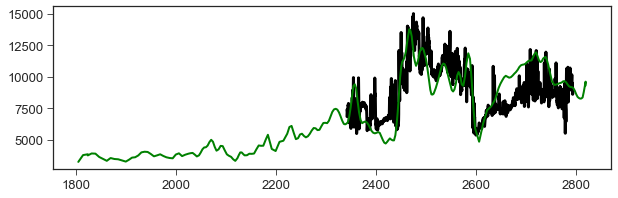

In [67]:
aiextr1_t = RegularGridInterpolator((x_seis, t_ainvt), 
                                    aiinvt_fence, 
                                    bounds_error=False, 
                                    fill_value=np.nan)(np.vstack((x_seis, twell)).T)

aiextr1_t_int = RegularGridInterpolator((xfence, t_ainvt),
                                        aiinvt_fence, 
                                        bounds_error=False,
                                        fill_value=np.nan)(np.vstack((xfence_int, twell_int)).T)

nsmooth=5
plt.figure(figsize=(10, 3))
plt.plot(well_twt, 
         filtfilt(np.ones(nsmooth)/nsmooth, 1, well_ai),  
         'k', lw=3, label='AI log (t)')
plt.plot(twell_int, aiextr1_t_int, 'g', lw=2);

## Estimate wavelet

Window data and velocity model to area of interest

In [53]:
tmin, tmax = 1900, 3200
itmin, itmax = int((tmin-t_seis[0])/dt), int((tmax-t_seis[0])/dt)

vint_fence = vint_fence[:, itmin:itmax]
seismic_fence = seismic_fence[:, itmin:itmax]
t_cut = t_seis[itmin:itmax]

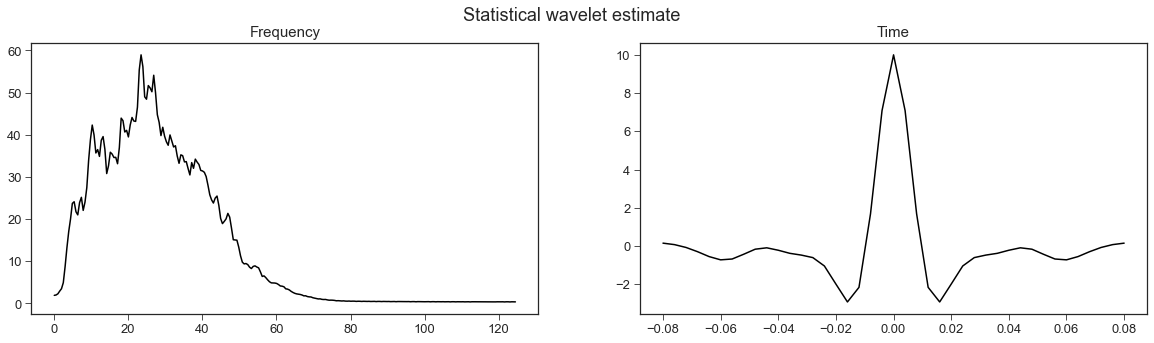

In [54]:
nt_wav = 21 # number of samples of statistical wavelet
nfft = 512 # number of samples of FFT
wav_scaling = 1e1

# Wavelet time axis
t_wav = np.arange(nt_wav) * (dt/1000)
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# Estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(seismic_fence, nfft, axis=-1)), axis=0)
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# Create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wav_est *= wav_scaling

# Display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');

## Well tie

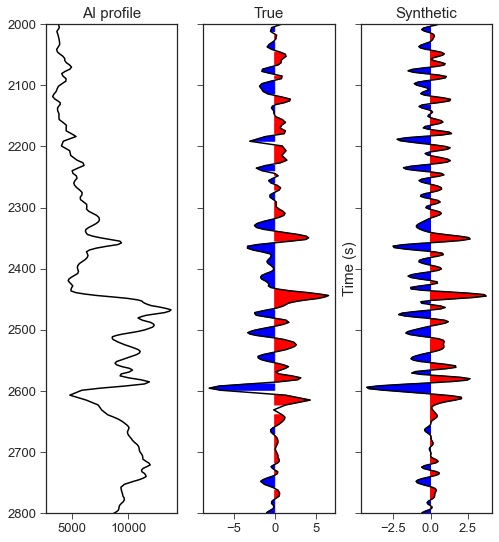

In [160]:
# Interpolate AI log over regular time axis
twell_int_reg = np.linspace(np.nanmin(twell_int),  np.nanmax(twell_int), 1001)
aiextr1_t_int_reg = np.interp(twell_int_reg, twell_int, aiextr1_t_int)
aiextr1_t_int_reg[np.isnan(aiextr1_t_int_reg)] = np.nanmin(aiextr1_t_int_reg)

# Model synthetic 
Lop = PoststackLinearModelling(wav_est, nt0=aiextr1_t_int_reg.size)
dwell = Lop * aiextr1_t_int_reg

# Extract seismic along well
d_seis = RegularGridInterpolator((x_seis, t_seis), 
                                 seismic_fence,
                                 bounds_error=False,
                                 fill_value=np.nan)(np.vstack((xfence_int, twell_int)).T)

# Model synthetic 
Lop = PoststackLinearModelling(wav_est, nt0=aiextr1_t_int_reg.size)
d_log = Lop * np.log(aiextr1_t_int_reg)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(8, 9))
axs[0].plot(aiextr1_t_int, twell_int, 'k')
axs[0].set_title('AI profile')
axs[1].plot(d_seis, twell_int, 'k')
axs[1].fill_betweenx(twell_int, 0, d_seis, where=np.array(d_seis)>0, color='r')
axs[1].fill_betweenx(twell_int, 0, d_seis, where=np.array(d_seis)<0, color='b')
axs[1].set_title('True')
axs[2].plot(d_log, twell_int_reg, 'k')
axs[2].fill_betweenx(twell_int_reg, 0, d_log, where=np.array(d_log)>0, color='r')
axs[2].fill_betweenx(twell_int_reg, 0, d_log, where=np.array(d_log)<0, color='b')
axs[2].set_ylabel('Time (s)')
axs[2].set_title('Synthetic')
axs[2].set_ylim(2800, 2000);